In [1]:
from collections import Counter, defaultdict
from matplotlib.path import Path
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import KDTree
from scipy.stats import gaussian_kde
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import parallel_backend
from wordcloud import WordCloud, get_single_color_func
import jieba
import jieba.analyse
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import openpyxl
import networkx as nx
import numpy as np
import pandas as pd
import re
import seaborn as sns


In [2]:
#读取前先执行Data_Preprocessing.py进行预处理
#文件读取
all_comments = pd.read_csv('C:/Users/12748/Desktop/GraduateProjectCode/Collected_Data/all_comments.csv',names=['comments_content','sentiment','positive_prob','neutral_prob','negative_prob'])
neg_comments = pd.read_csv('C:/Users/12748/Desktop/GraduateProjectCode/Collected_Data/neg_comments.csv',names=['comments_content','sentiment','positive_prob','neutral_prob','negative_prob'])
all_comments_preprocessed = pd.read_csv('C:/Users/12748/Desktop/GraduateProjectCode/Collected_Data/all_comments_preprocessed.csv')
positive_comments_preprocessed = all_comments_preprocessed[all_comments_preprocessed['sentiment'] == '正面']
neutral_comments_preprocessed = all_comments_preprocessed[all_comments_preprocessed['sentiment'] == '中性']
negative_comments_preprocessed = all_comments_preprocessed[all_comments_preprocessed['sentiment'] == '负面']
all_comments_preprocessed.shape

(1824789, 7)

In [64]:
positive_prob_average = all_comments_preprocessed['positive_prob'].mean()
neutral_prob_average = all_comments_preprocessed['neutral_prob'].mean()
negative_prob_average = all_comments_preprocessed['negative_prob'].mean()
print(positive_prob_average)
print(neutral_prob_average)
print(negative_prob_average)

0.6637729724368128
0.06299655362894015
0.27308070944092716


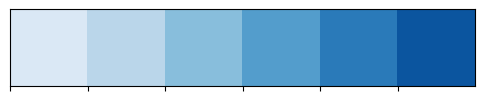

In [16]:
## 烟蓝色基调确立
sns.set()
plt.rcdefaults()
sns.palplot(sns.color_palette("Blues"))
plt.rcParams['font.sans-serif'] = ['SimHei']  #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  #用来正常显示负号

C:\Users\12748\AppData\Local\Temp\ipykernel_113472\2985632040.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='sentiment', y='count', data=category_counts, palette='Blues_r')


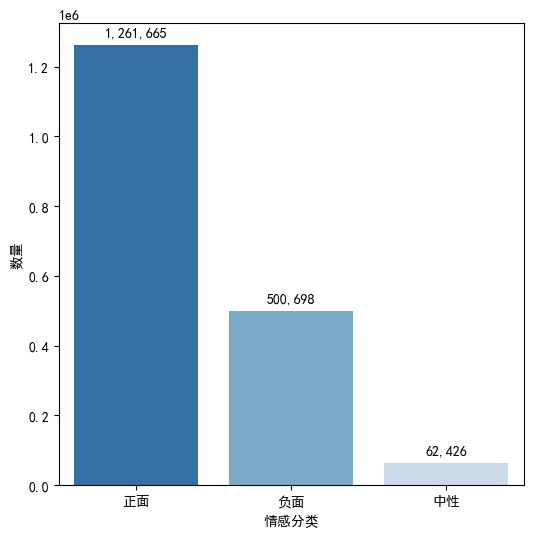

In [4]:
## 正面负面评论统计
# 第一步：计算每个类别的出现次数
category_counts = all_comments['sentiment'].value_counts().reset_index()
category_counts.columns = ['sentiment', 'count']

# 第二步：使用Seaborn绘制条形图
plt.figure(figsize=(6, 6))
barplot = sns.barplot(x='sentiment', y='count', data=category_counts, palette='Blues_r')

plt.xlabel('情感分类')
plt.ylabel('数量')


# 在每个柱子顶部显示计数值
for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{height:,.0f}',  # 使用千分位分隔符格式化文本
                     (p.get_x() + p.get_width() / 2., height), 
                     ha='center', va='center', 
                     xytext=(0, 9), 
                     textcoords='offset points')
plt.savefig('C:/Users/12748/Desktop/GraduateProjectCode/Analysis_Documents/bar_chart.png', dpi=300,transparent=True)
plt.show()

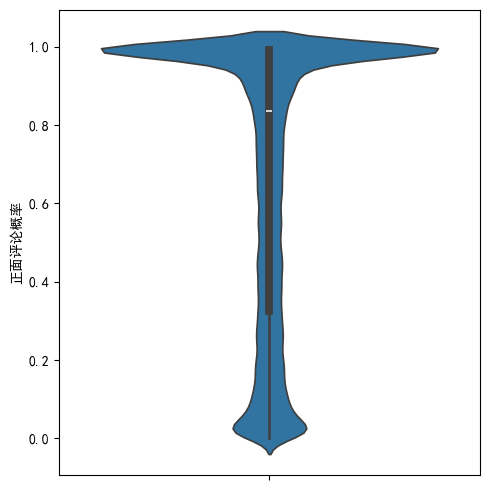

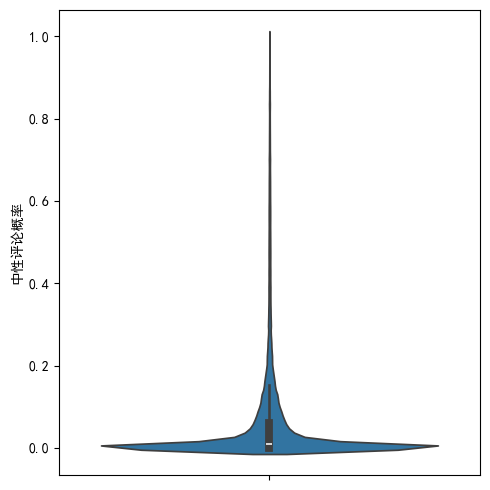

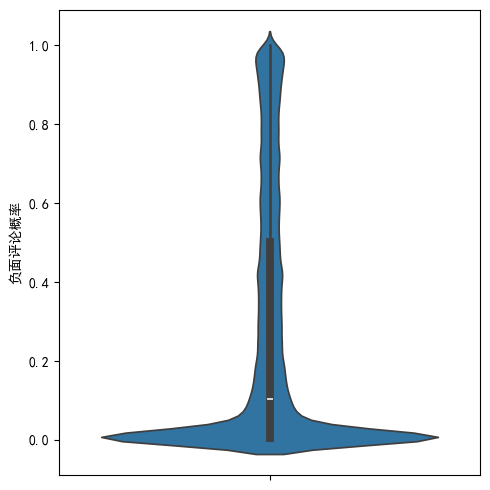

In [13]:
# 绘制积极评论概率分数分布的小提琴图
plt.figure(figsize=(5, 5))
sns.violinplot(y=all_comments['positive_prob'])
plt.ylabel('正面评论概率')
plt.tight_layout()
plt.savefig('C:/Users/12748/Desktop/GraduateProjectCode/Analysis_Documents/Violin_positive_prob.png', dpi=300)
plt.show()

# 绘制中性评论概率分数分布的小提琴图
plt.figure(figsize=(5, 5))
sns.violinplot(y=all_comments['neutral_prob'])
plt.ylabel('中性评论概率')
plt.tight_layout()
plt.savefig('C:/Users/12748/Desktop/GraduateProjectCode/Analysis_Documents/Violin_neutral_prob.png', dpi=300)
plt.show()

# 绘制消极评论概率分数分布的小提琴图
plt.figure(figsize=(5, 5))
sns.violinplot(y=all_comments['negative_prob'])
plt.ylabel('负面评论概率')
plt.savefig('C:/Users/12748/Desktop/GraduateProjectCode/Analysis_Documents/Violin_negative_prob.png', dpi=300)
plt.tight_layout()
plt.show()

In [6]:
## 三维分布
df = pd.DataFrame(all_comments, columns=['positive_prob', 'neutral_prob', 'negative_prob'])

# 使用 KDTree 查找每个点的最近邻距离
tree = KDTree(df)
distances, _ = tree.query(df, k=2)  # k=2 因为最近的点是其自身
density = 1 / distances[:, 1]  # 使用最近邻距离的倒数作为密度的简单估计



C:\Users\12748\AppData\Local\Temp\ipykernel_113472\4020936865.py:7: RuntimeWarning: divide by zero encountered in divide
  density = 1 / distances[:, 1]  # 使用最近邻距离的倒数作为密度的简单估计


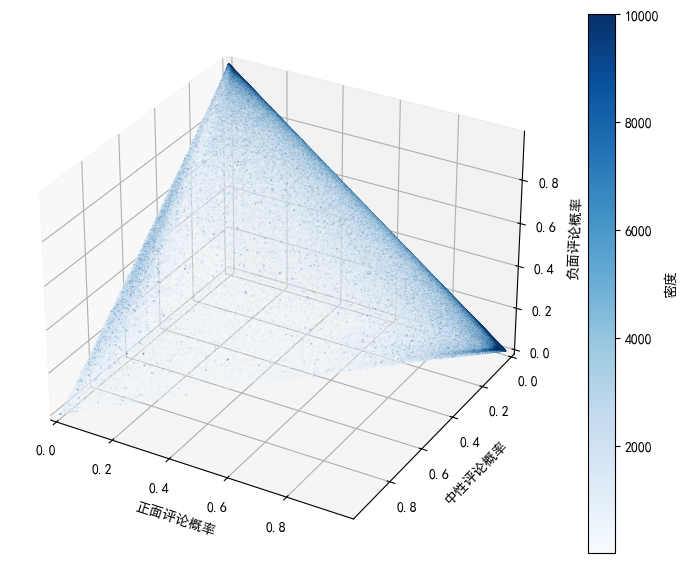

In [9]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 绘制三维散点图，这里交换了positive_prob和negative_prob的位置
scatter = ax.scatter(df['positive_prob'], df['neutral_prob'], df['negative_prob'], c=density, cmap='Blues', s=0.03)

# 添加颜色条
fig.colorbar(scatter, ax=ax, label='密度')

# 设置图表标题和坐标轴标签

ax.set_xlabel('正面评论概率')
ax.set_ylabel('中性评论概率')
ax.set_zlabel('负面评论概率')

# 手动设置坐标轴的范围以对齐0点
ax.set_xlim([0, df['positive_prob'].max()])
ax.set_ylim([ df['neutral_prob'].max(),0])
ax.set_zlim([0, df['negative_prob'].max()])

plt.savefig('C:/Users/12748/Desktop/GraduateProjectCode/Analysis_Documents/3D_Density.png', dpi=300,transparent=True)
plt.show()

负面评论计算结果


,word,count,Probability(%),tfidf
26660,裤子,33959,2.378728,12501.074856
15135,拍,24486,1.715172,11758.130753
7817,号,23361,1.636369,10866.836887
18993,没,23538,1.648767,10601.474027
2363,中,17498,1.225683,8766.245895
23162,穿,17389,1.218048,7465.004467
2759,买,18051,1.264419,6953.391674
28068,身上,9645,0.675604,5199.684160
30563,鞋子,21349,1.495434,4965.002539
31585,黑色,12129,0.849601,4708.261451


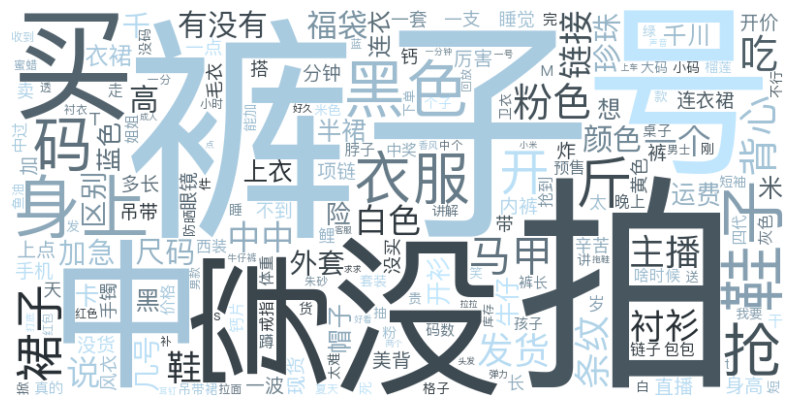

,word,count,Probability(%),tfidf
26660,裤子,33959,2.378728,12501.074856
15135,拍,24486,1.715172,11758.130753
7817,号,23361,1.636369,10866.836887
18993,没,23538,1.648767,10601.474027
2363,中,17498,1.225683,8766.245895
23162,穿,17389,1.218048,7465.004467
2759,买,18051,1.264419,6953.391674
28068,身上,9645,0.675604,5199.684160
30563,鞋子,21349,1.495434,4965.002539
31585,黑色,12129,0.849601,4708.261451


In [66]:
## Tf-idf分析，词频逆文档频率
class SimpleGroupedColorFunc(object):
    """为每个词创建基于单一颜色的颜色函数"""
    def __init__(self, color):
        self.color = color
    
    def __call__(self, word, **kwargs):
        return self.color
# 定义烟蓝色
smoke_blue = "#6a7f8c"

def generate_tfidf_wordcloud(df, sentiment=None, color="#6a7f8c"):
    """
    根据给定的情感类别，生成包含词频、出现频率、TF-IDF值的表格，并绘制词云图。
    参数:
    - df: DataFrame，包含所有评论和相关信息。
    - sentiment: 情感类别（'正面'、'中性'、'负面'），若为None，则考虑所有评论。
    - color: 词云图中词的颜色。
    """
    # 筛选特定情感类别的评论，如果sentiment为None，则使用全部评论
    if sentiment:
        filtered_df = df[df['sentiment'] == sentiment]
    else:
        filtered_df = df
    filtered_sentences = filtered_df['filtered_sentences'].dropna().tolist()
    
    # 计算TF-IDF
    tfidf_vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b", lowercase=False)
    tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_sentences)
    tfidf_sum = tfidf_matrix.sum(axis=0)
    words = tfidf_vectorizer.get_feature_names_out()
    tfidf_scores = np.array(tfidf_sum).flatten()

    # 计算词频
    all_words = ','.join(filtered_sentences).split(',')
    word_counts = Counter(all_words)
    total_words = sum(word_counts.values())
    
    # 构建表格
    data = []
    for word, tfidf in zip(words, tfidf_scores):
        count = word_counts.get(word, 0)
        probability = (count / total_words) * 100
        data.append([word, count, probability, tfidf])

    df_result = pd.DataFrame(data, columns=['word', 'count', 'Probability(%)', 'tfidf'])
    df_result = df_result.sort_values(by='tfidf', ascending=False)

    # 生成词云
    wordcloud = WordCloud(font_path='C:/Users/12748/Desktop/GraduateProjectCode/Analysis_Documents/pingfangs.ttf', width=800, height=400, background_color='white',color_func=get_single_color_func(smoke_blue)).generate_from_frequencies(dict(zip(words, tfidf_scores)))
    
    # 显示表格的前20行
    if sentiment is None:
        print('全部评论计算结果')
    else:
        print(f'{sentiment}评论计算结果')
    display(df_result.head(20))

    # 绘制词云图
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    return df_result.head(20)  # 返回表格的前20行供进一步分析

#generate_tfidf_wordcloud(all_comments_preprocessed)
#generate_tfidf_wordcloud(all_comments_preprocessed,sentiment='正面')
#generate_tfidf_wordcloud(all_comments_preprocessed,sentiment='中性')
generate_tfidf_wordcloud(all_comments_preprocessed,sentiment='负面')

In [12]:
## 共线矩阵函数设计
def create_limited_cooccurrence_matrix(df, column_name, max_vocab_size=1000):
    # 统计所有词的出现频率
    all_words_counter = Counter()
    for text in df[column_name].dropna():
        all_words_counter.update(text.split(','))
    # 选择出现频率最高的max_vocab_size个词
    most_common_words = [word for word, count in all_words_counter.most_common(max_vocab_size)]
    # 创建词汇表索引
    word_index = {word: idx for idx, word in enumerate(most_common_words)}
    # 初始化共现字典
    cooccur_counter = Counter()
    # 遍历数据集中的每一行，只考虑最高频的词汇
    for text in df[column_name].dropna():
        words = set(text.split(','))
        # 过滤出最高频的词汇
        words = [word for word in words if word in word_index]
        # 统计共现
        for i, word1 in enumerate(words):
            for word2 in words[i+1:]:
                if word1 != word2:  # 避免自己与自己共现
                    idx1, idx2 = sorted([word_index[word1], word_index[word2]])
                    cooccur_counter[(idx1, idx2)] += 1
    # 创建共现矩阵
    cooccurrence_matrix = pd.DataFrame(
        data=0, 
        index=most_common_words, 
        columns=most_common_words
    )
    # 填充共现矩阵
    for (word1_idx, word2_idx), count in cooccur_counter.items():
        word1 = most_common_words[word1_idx]
        word2 = most_common_words[word2_idx]
        cooccurrence_matrix.at[word1, word2] = count
        cooccurrence_matrix.at[word2, word1] = count  # 使矩阵对称
    return cooccurrence_matrix


In [14]:
## 共现网络图绘制函数定义

def draw_curved_edges(G, pos, edges, alpha=0.2, edge_color='black'):
    """自定义函数绘制曲线边"""
    for edge in edges:
        p1 = pos[edge[0]]
        p2 = pos[edge[1]]
        # 计算边的曲率
        dx, dy = p2 - p1
        curve_radius = np.sqrt(dx**2 + dy**2) / 3
        curve_direction = np.array([-dy, dx]) / np.linalg.norm([dx, dy]) * curve_radius
        control_point = (p1 + p2) / 2 + curve_direction
        
        # 生成曲线路径
        curve_path = np.array([p1, control_point, p2])
        codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3]
        path = Path(curve_path, codes)
        patch = patches.PathPatch(path, facecolor='none', edgecolor=edge_color, alpha=alpha)
        plt.gca().add_patch(patch)

def draw_cooccurrence_network(cooccurrence_matrix,top_n_edges=500, min_size=10, max_size=5000):
    G = nx.Graph()
    
    # 基于共现频率调整节点大小
    frequencies = cooccurrence_matrix.sum(axis=1) + cooccurrence_matrix.sum(axis=0)
    min_freq = frequencies.min()
    max_freq = frequencies.max()
    # 修正：使用items()而不是iteritems()
    node_sizes = {word: ((freq - min_freq) / (max_freq - min_freq) * (max_size - min_size) + min_size) for word, freq in frequencies.items()}

    
    # 添加节点和边
    for word1 in cooccurrence_matrix.columns:
        for word2 in cooccurrence_matrix.index:
            weight = cooccurrence_matrix.at[word1, word2]
            if weight > 0:
                G.add_edge(word1, word2, weight=weight)
                
    # 只保留权重最高的top_n_edges条边
    if top_n_edges is not None:
        edges_to_remove = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[top_n_edges:]
        G.remove_edges_from([(edge[0], edge[1]) for edge in edges_to_remove])
    
    pos = nx.spring_layout(G, k=5, iterations=20)
    
    # 节点颜色映射
    cmap = plt.get_cmap('coolwarm')
    node_colors = [cmap((size - min(node_sizes.values())) / (max(node_sizes.values()) - min(node_sizes.values()))) for node, size in node_sizes.items()]
    
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=[size for size in node_sizes.values()], node_color=node_colors, alpha=0.6)
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold', font_color='black')
    
    # 使用自定义函数绘制曲线边
    draw_curved_edges(G, pos, G.edges(), alpha=0.4, edge_color='silver')
    plt.savefig('C:/Users/12748/Desktop/GraduateProjectCode/Analysis_Documents/Co-occurrence.png', dpi=300,transparent=True)
    plt.axis('off')
    plt.show()


负面评论共现矩阵与共现网络图


,裤子,拍,没,号,鞋子,买,中,穿,黑色,身上,...,粉,卡,益生菌,蓝,双肩包,搭,小米,开价,太,上点
裤子,0,1115,659,1084,89,421,4,1569,667,1603,...,109,124,0,42,0,276,0,96,36,60
拍,1115,0,2855,886,232,230,82,282,212,95,...,28,762,24,10,8,80,3,51,24,20
没,659,2855,0,512,229,842,1689,204,184,88,...,35,37,2,39,13,53,5,57,30,80
号,1084,886,512,0,103,254,71,529,199,55,...,12,8,8,28,2,50,0,609,4,102
鞋子,89,232,229,103,0,124,1,119,132,43,...,16,1,0,1,0,29,0,36,2,20
买,421,230,842,254,124,0,559,335,174,48,...,20,35,32,16,1,52,10,27,100,16
中,4,82,1689,71,1,559,0,6,17,1,...,0,0,0,0,0,4,3,0,30,1
穿,1569,282,204,529,119,335,6,0,409,408,...,13,3,0,6,0,100,0,10,23,6
黑色,667,212,184,199,132,174,17,409,0,111,...,2,4,0,0,29,105,0,5,4,28
身上,1603,95,88,55,43,48,1,408,111,0,...,20,7,0,8,0,47,1,14,2,28


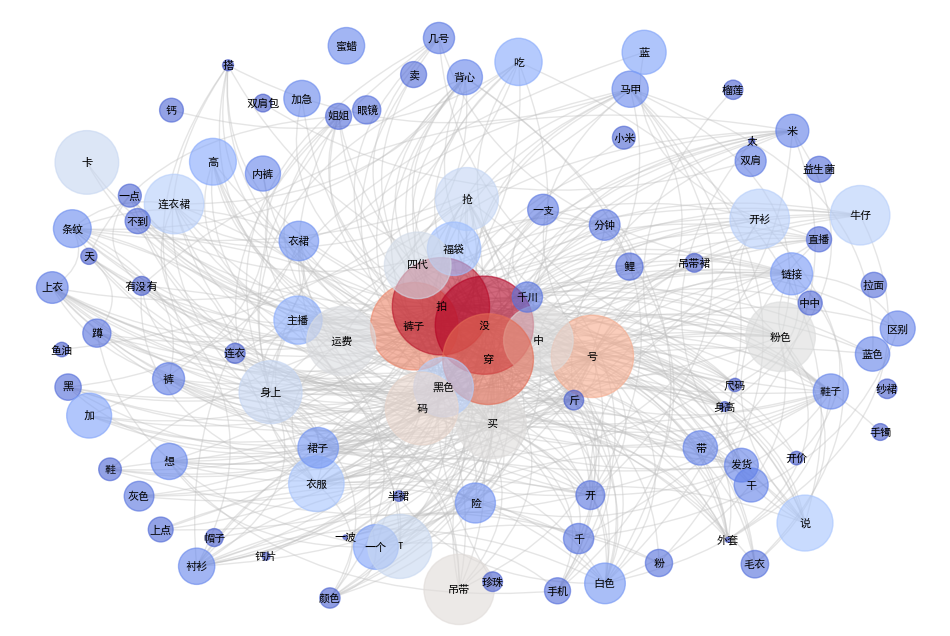

In [17]:
'''
print('全部评论共现矩阵与共现网络图')
cooccurrence_matrix = create_limited_cooccurrence_matrix(all_comments_preprocessed, 'filtered_sentences', 100)
display(cooccurrence_matrix.head(10))
draw_cooccurrence_network(cooccurrence_matrix)

print('正面评论共现矩阵与共现网络图')
cooccurrence_matrix = create_limited_cooccurrence_matrix(positive_comments_preprocessed, 'filtered_sentences', 100)
display(cooccurrence_matrix.head(10))
draw_cooccurrence_network(cooccurrence_matrix)

print('中性评论共现矩阵与共现网络图')
cooccurrence_matrix = create_limited_cooccurrence_matrix(neutral_comments_preprocessed, 'filtered_sentences', 100)
display(cooccurrence_matrix.head(10))
draw_cooccurrence_network(cooccurrence_matrix)
'''

print('负面评论共现矩阵与共现网络图')
cooccurrence_matrix = create_limited_cooccurrence_matrix(negative_comments_preprocessed, 'filtered_sentences', 100)
display(cooccurrence_matrix.head(10))
draw_cooccurrence_network(cooccurrence_matrix)

In [34]:
cooccurrence_matrix.to_excel('C:/Users/12748/Desktop/GraduateProjectCode/Analysis_Documents/cooccurrence_matrix.xlsx', index=True)


In [18]:
## LDA主题模型函数定义，使用TF-IDF：
def LDA_model_with_TFIDF(df):
    # 仅选择comments_content列字符数大于10的行
    df = df[df['comments_content'].str.len() > 10]
    
    # 准备数据：移除NaN值并将列转换为字符串列表
    filtered_sentences = df['filtered_sentences'].dropna().tolist()
    
    # 创建TF-IDF文档-词项矩阵
    vectorizer = TfidfVectorizer()
    data_vectorized = vectorizer.fit_transform(filtered_sentences)
    
    # 构建LDA模型
    lda_model = LatentDirichletAllocation(n_components=5,  # 假设我们想要识别5个主题
                                          learning_method='online',
                                          random_state=0)
    
    # 将模型拟合到数据集
    lda_model.fit(data_vectorized)
    
    # 获取特征名称（词汇）
    feature_names = vectorizer.get_feature_names_out()
    
    # 函数展示每个主题的顶部词汇
    def display_topics(model, feature_names, no_top_words):
        topic_dict = {}
        for topic_idx, topic in enumerate(model.components_):
            top_features_ind = topic.argsort()[:-no_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            top_weights = [round(topic[i], 2) for i in top_features_ind]
            topic_dict[f"Topic {topic_idx}"] = list(zip(top_features, top_weights))
        return topic_dict
    
    # 展示每个主题的前20个词汇
    top_words_per_topic = display_topics(lda_model, feature_names, 20)
    topic_df = pd.DataFrame.from_dict(top_words_per_topic, orient='index').transpose()
    display(topic_df)
    topic_df.to_excel('C:/Users/12748/Desktop/GraduateProjectCode/Analysis_Documents/Co-topic_df.xlsx')
    # 展示DataFrame
    return topic_df

In [37]:
## LDA词云图
class SimpleGroupedColorFunc(object):
    """为每个词创建基于单一颜色的颜色函数"""
    def __init__(self, color):
        self.color = color
    
    def __call__(self, word, **kwargs):
        return self.color
# 定义烟蓝色
smoke_blue = "#6a7f8c"
def plot_topic_wordclouds(topic_df):

    # 创建一个matplotlib的子图序列，5个主题对应5个词云图
    fig, axes = plt.subplots(1, 5, figsize=(20, 10))

    # 遍历每个主题，生成并绘制词云
    for index, (column, ax) in enumerate(zip(topic_df.columns, axes.flatten())):
        # 将DataFrame中的单词和权重转换为WordCloud能理解的字典格式
        words_freq = {word_weight[0]: word_weight[1] for word_weight in topic_df[column].dropna().values}
        # 创建词云对象
        wordcloud = WordCloud(font_path='C:/Users/12748/Desktop/GraduateProjectCode/Analysis_Documents/pingfangs.ttf', width=800, height=400, background_color='white',color_func=get_single_color_func(smoke_blue)).generate_from_frequencies(words_freq)
        # 显示词云图
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f'Topic {index}')
    plt.savefig('C:/Users/12748/Desktop/GraduateProjectCode/Analysis_Documents/topic.png', dpi=300,transparent=True)
    plt.tight_layout()
    plt.show()

In [20]:
negative_topic_df = LDA_model_with_TFIDF(negative_comments_preprocessed)

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,"(身高, 1089.75)","(白色, 561.11)","(福袋, 906.16)","(鞋子, 1548.08)","(裤子, 2467.23)"
1,"(体重, 884.34)","(帽子, 524.93)","(一个, 851.11)","(黑色, 1069.41)","(链接, 1054.32)"
2,"(衣服, 844.25)","(上衣, 328.22)","(千川, 835.97)","(身上, 634.34)","(裙子, 855.12)"
3,"(主播, 757.42)","(眼霜, 318.47)","(分钟, 810.85)","(粉色, 506.5)","(背心, 725.47)"
4,"(马甲, 723.63)","(预售, 310.99)","(发货, 625.83)","(运费, 457.05)","(衬衫, 609.14)"
5,"(条纹, 647.42)","(不到, 300.05)","(一支, 615.51)","(榴莲, 350.58)","(手机, 528.15)"
6,"(区别, 642.8)","(一点, 288.95)","(四代, 590.09)","(多大码, 303.42)","(晚上, 466.14)"
7,"(直播, 583.42)","(收到, 257.02)","(珍珠, 429.05)","(短袖, 253.47)","(吊带, 368.53)"
8,"(牛仔, 511.64)","(你家, 251.47)","(一分, 418.01)","(理由, 252.95)","(小时, 344.93)"
9,"(外套, 477.84)","(防晒, 241.19)","(一分钟, 405.67)","(风衣, 241.42)","(讲解, 319.51)"


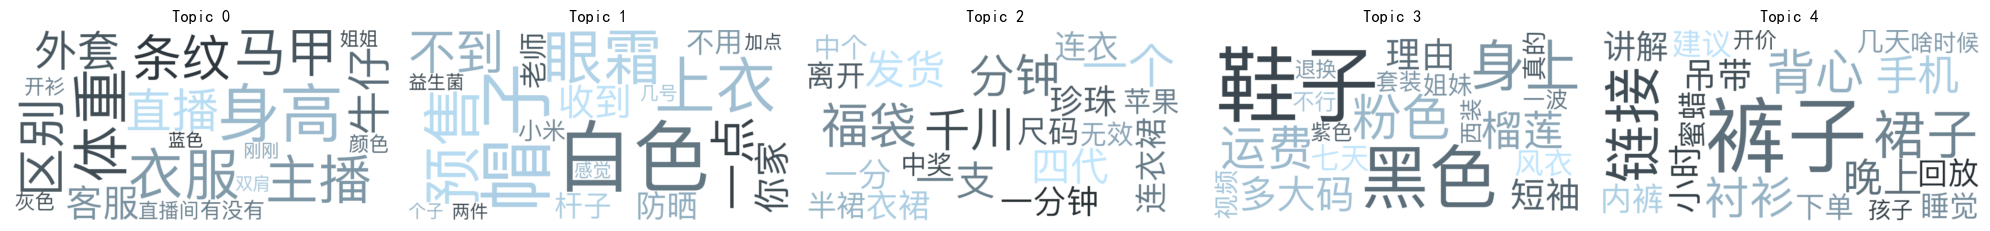

In [38]:
plot_topic_wordclouds(negative_topic_df)

## 对上面进行解读
topic0:直播主体
topic1:带货产品
topic2:互动活动
topic3:物流保障
topic4:系统服务